In [1]:
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose)
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

In [2]:
# loading the training and test sets from TFRecords
train_data = tf.data.TFRecordDataset('data/train_images.tfrecords')
val_data    = tf.data.TFRecordDataset('data/val_images.tfrecords')

In [3]:
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [4]:
#function to extract image from the dictionary 
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [14]:
parsed_train_data = train_data.map(_parse_image_function)
parsed_val_data=val_data.map(_parse_image_function)
print(len(list(parsed_train_data)))
print(len(list(parsed_val_data)))

234
26


Right now, our images are in bytes and don't much resemble and image. Let's fix that! We'll make a function that will convert the bytes into a vector of integers. That's still not quite an image, so tf.reshape is used to make it into a square 256x256x1 array, where each cell represents a greyscale pixel.

In [12]:
#function to convert bytes too a vector of integers
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [15]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train =parsed_train_data.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_data.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [16]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [17]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

# Visualization

In [18]:
# function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

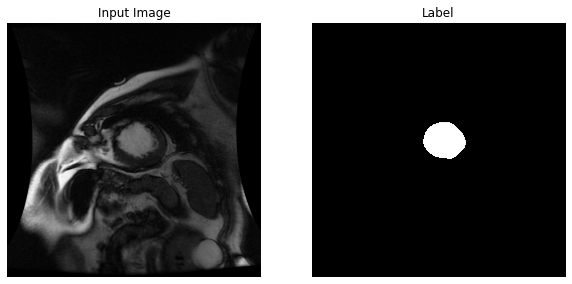

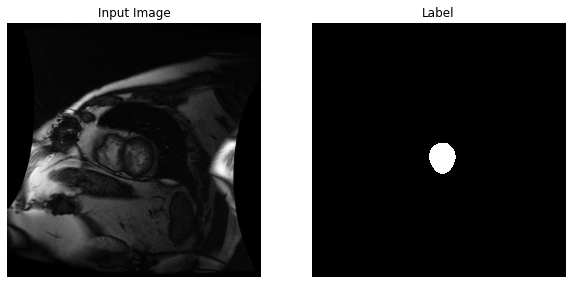

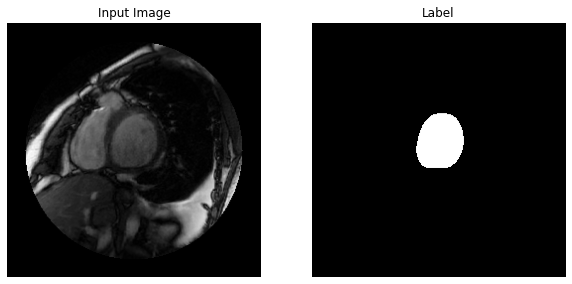

In [19]:
# display 3 random images and labels from the training set
for image, label in train.take(3):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

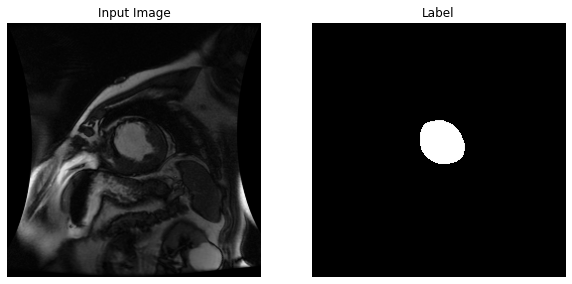

In [20]:
# an image and label from validation data
for image, label in val.take(1):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

# Building the Keras model
The input will be the value of each pixel
Since the images are black and white we'll use 1 color channel.The layer expects a vector not a matrix so we'll flatten the image<br>
The hidden Dense layer will have a size that you can adjust to any positive integer.<br>
Each input can either be in two classes Left Ventricle(LV) or not so that will be the output then we will reshape it to view as an image.

In [49]:
tf.keras.backend.clear_session()

# set up the model architecture

# specify how to train the model with algorithm, the loss function and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [22]:
# print out the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4194368   
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            8519680   
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 2)       0         
Total params: 12,714,048
Trainable params: 12,714,048
Non-trainable params: 0
_________________________________________________________________


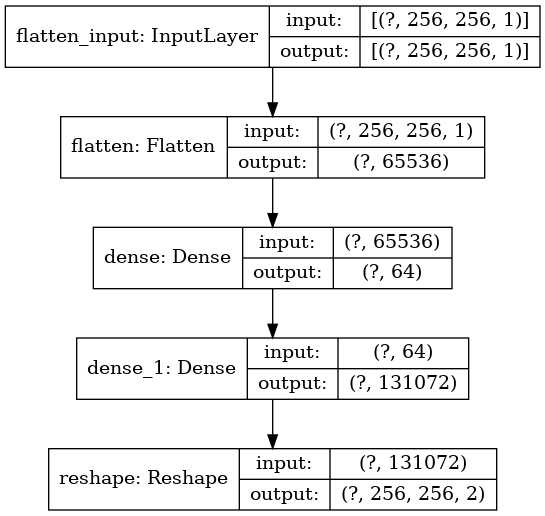

In [23]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
# function to take a prediction from the model and output an image for display

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [25]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

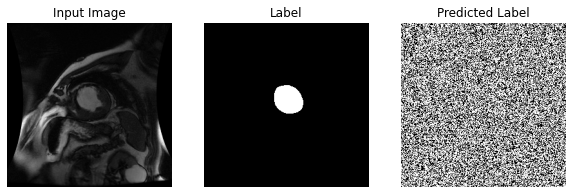

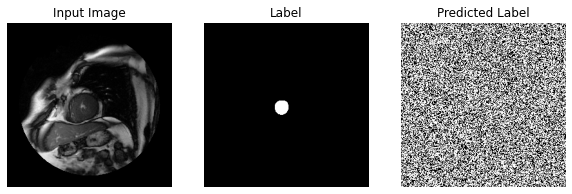

In [26]:
#example
show_predictions(test_dataset,2)

This will be the format of our output

In [41]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        
 # setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)       

# Training

In [42]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_train_data))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,    
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                         callbacks=[tensorboard_callback])  

Train for 234 steps, validate for 26 steps
Epoch 1/20
234/234 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 2/20
234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 3/20
234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 4/20
234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 5/20
234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 6/20
234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9866 - val_loss: 0.6931 - val_accuracy: 0.9867
Epoch 7/20
234/234 [==============================] - 2s 8ms/step - loss: 0.6931 - accuracy: 0.9866 - va

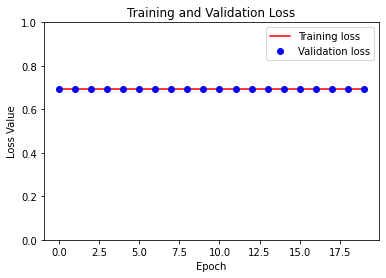

In [43]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Evaluatng the model

In [44]:
model.evaluate(test_dataset)

     26/Unknown - 0s 3ms/step - loss: 0.6931 - accuracy: 0.9867

[0.6931405067443848, 0.9866849]

# CNN with Dice Metric Loss

The Dice Metric is a metric to compare the similarity of two samples. In our case we'll use it to compare the two areas of interest, i.e., the area of the expertly-labelled contour and the area of our predicted contour.

In [50]:
def dice_coef(y_true, y_pred, smooth=1):
    indices = K.argmax(y_pred, 3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    true_cast = y_true
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

    return dice

In [53]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [56]:
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_train_data))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Train for 234 steps, validate for 26 steps
Epoch 1/20
234/234 [==============================] - 2s 9ms/step - loss: 0.5928 - accuracy: 0.9816 - val_loss: 0.5037 - val_accuracy: 0.9830
Epoch 2/20
234/234 [==============================] - 1s 5ms/step - loss: 0.4354 - accuracy: 0.9836 - val_loss: 0.3759 - val_accuracy: 0.9830
Epoch 3/20
234/234 [==============================] - 1s 5ms/step - loss: 0.3299 - accuracy: 0.9836 - val_loss: 0.2905 - val_accuracy: 0.9830
Epoch 4/20
234/234 [==============================] - 1s 5ms/step - loss: 0.2591 - accuracy: 0.9836 - val_loss: 0.2328 - val_accuracy: 0.9830
Epoch 5/20
234/234 [==============================] - 1s 5ms/step - loss: 0.2107 - accuracy: 0.9836 - val_loss: 0.1930 - val_accuracy: 0.9830
Epoch 6/20
234/234 [==============================] - 1s 5ms/step - loss: 0.1771 - accuracy: 0.9836 - val_loss: 0.1650 - val_accuracy: 0.9830
Epoch 7/20
234/234 [==============================] - 1s 5ms/step - loss: 0.1531 - accuracy: 0.9836 - val

In [57]:
model.evaluate(test_dataset)

     26/Unknown - 0s 4ms/step - loss: 0.0871 - accuracy: 0.9830

[0.08709566144702527, 0.9829577]

In [58]:
tf.keras.backend.clear_session() 
layers=layers
model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])

In [61]:
 # setting up and running the model using 30 passes
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_train_data))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset)
                       

Train for 234 steps
Epoch 1/30
234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 2/30
234/234 [==============================] - 1s 5ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 3/30
234/234 [==============================] - 1s 5ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 4/30
234/234 [==============================] - 1s 5ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 5/30
234/234 [==============================] - 1s 6ms/step - loss: 0.0836 - dice_coef: 0.0021 - accuracy: 0.9836 - val_loss: 0.0863 - val_dice_coef: 0.0049 - val_accuracy: 0.9830
Epoch 6/30
234/234 [==============================

In [62]:
model.evaluate(test_dataset)

     26/Unknown - 0s 5ms/step - loss: 0.0863 - dice_coef: 0.0049 - accuracy: 0.9830

[0.08629969249551113, 0.0048775296, 0.9829577]